In [31]:
pip install pandas networkx scikit-learn matplotlib

In [2]:
import kagglehub

path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")



100%|██████████| 41.0M/41.0M [00:01<00:00, 24.1MB/s]

Extracting files...


In [12]:
import pandas as pd

# Load dataset
df_fake = pd.read_csv(f'{path}/fake.csv')  # Adjust the file name/path if needed
df_true = pd.read_csv(f'{path}/true.csv')  # Adjust the file name/path if needed

df_fake['label'] = 0
df_true['label'] = 1

data = pd.concat([df_fake, df_true], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

print(data['label'].value_counts())
#sample data

data = data.sample(frac=0.1, random_state=42)


                                               title  \
0  'Furious race against time' to complete Brexit...   
1          Trump Halts Travel In New Executive Order   
2  Is the United States of America a Liberal Demo...   
3  Close but no hurrah: EU welcomes May Brexit sp...   
4   Neil DeGrasse Tyson Just Called Trump Support...   

                                                text    subject  \
0  BRUSSELS (Reuters) - European Council Presiden...  worldnews   
1  21st Century Wire says After President Donald ...    US_News   
2  21st Century Wire says Does the American ideal...    US_News   
3  BRUSSELS (Reuters) - Theresa May s  constructi...  worldnews   
4  It s one thing to go after Donald Trump and ho...       News   

                  date  label  
0   December 12, 2017       1  
1        March 6, 2017      0  
2         June 8, 2017      0  
3  September 22, 2017       1  
4         June 4, 2016      0  
label
0    23481
1    21417
Name: count, dtype: int64


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Create the graph
news_graph = nx.Graph()

# Add nodes (one for each article)
for index, row in data.iterrows():
    news_graph.add_node(index, label=row['label'])

# Add edges for shared subjects
subject_groups = data.groupby('subject')
for subject, group in subject_groups:
    indices = group.index
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            news_graph.add_edge(indices[i], indices[j])

# Add edges based on title similarity
vectorizer = TfidfVectorizer(stop_words='english')
title_vectors = vectorizer.fit_transform(data['title'])
similarity_matrix = cosine_similarity(title_vectors)

# Lower threshold for similarity
similarity_threshold = 0.1
for i in range(similarity_matrix.shape[0]):
    for j in range(i + 1, similarity_matrix.shape[1]):
        if similarity_matrix[i, j] > similarity_threshold:
            news_graph.add_edge(i, j)

# Print updated graph properties
print(f"Graph has {news_graph.number_of_nodes()} nodes and {news_graph.number_of_edges()} edges.")


Graph has 8504 nodes and 2029142 edges.


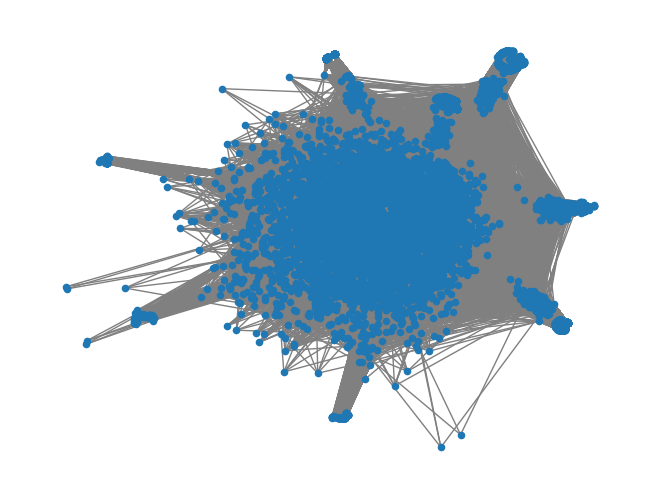

In [27]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(news_graph)
nx.draw(news_graph, pos, with_labels=False, node_size=20, edge_color='gray')
plt.show()

In [28]:
# Step 3: Extract network features
degree_centrality = nx.degree_centrality(news_graph)
clustering_coefficient = nx.clustering(news_graph)

  # Drop rows with NaN values

# Prepare the feature matrix
features = pd.DataFrame({
    'degree_centrality': pd.Series(degree_centrality),
    'clustering_coefficient': pd.Series(clustering_coefficient),
})

# Add the label column
features['label'] = data['label'].reindex(features.index)

features = features.dropna()
# Display the feature matrix
print(features.isnull().sum())
print(features.head())


degree_centrality         0
clustering_coefficient    0
label                     0
dtype: int64
       degree_centrality  clustering_coefficient  label
22216           0.018699                1.000000    0.0
27917           0.121369                1.000000    1.0
25007           0.077620                1.000000    0.0
1377            0.127014                0.913468    1.0
32476           0.106551                1.000000    0.0


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Step 4: Split the data into training and testing sets
X = features[['degree_centrality','clustering_coefficient']]
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values in y_train (choose ONE of the following strategies)
#Strategy 1: Remove rows with missing values
train_data = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_data[['degree_centrality','clustering_coefficient']]
y_train = train_data['label']

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train,y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.8173719376391982
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.65      0.78       462
         1.0       0.73      1.00      0.84       436

    accuracy                           0.82       898
   macro avg       0.86      0.82      0.81       898
weighted avg       0.87      0.82      0.81       898

Precision: 0.7266666666666667
Recall: 1.0
F1 Score: 0.8416988416988417


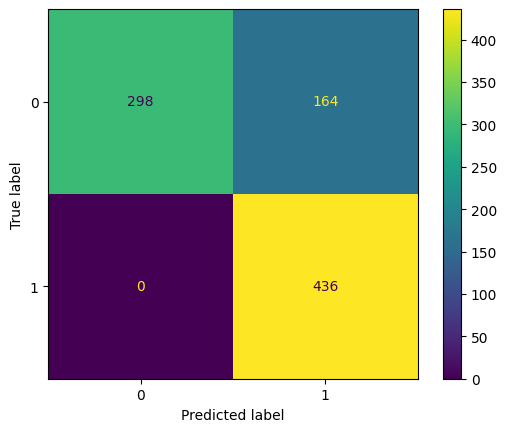

In [30]:
#Visualize Results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
